# CAML ClinicalBERT

This Jupyter Notebook file is a substitute for the original file I created for the project. Initially I was going to be reproducing the work of Nwamake Imasogie using MIMIC-III data, but because of a snafu with PhysioNet, I have had to resort to using the CAML data from one of the homework assignments. The preprocessing of this data is described in detail in prep_caml_data.ipynb, where I convert the original CAML data to a simple dataset containing TEXT and LABEL fields. Unlike the original CAML data, the LABEL is a binary value based on the first value found in the original CAML dataset's Label field.

Since all the NLP-style preprocessing is done in the other notebook, in this notebook, I simply import the CAML data I prepared in that notebook and run the same version of ClinicalBERT that Nwamake Imasogie used for her study.

In [207]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May  7 19:19:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   9175MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [208]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from tqdm import tqdm, trange

In [210]:
!pip install transformers

In [211]:
!pip install boto3

#### File locations will differ depending on whether running on colab or your own machine
- On colab, you need to place files in your drive.
- On your own computer, file structure is as described below.

In [212]:
# Set these flags depending on whether running on Colab or your own machine
# I may end up adding other flags if I create new environments
on_mac = False
on_colab = True

In [213]:
if on_mac == True:
    results_location = 'results'
    clean_caml_path = 'clean_caml.csv'
    caml_data_folder = 'caml_data'
    bert_model_folder = './model' # location simplified from original code

    if os.path.isdir(results_location):
        !rmdir results
        # raise SystemExit(f'You need to move {results_location} before running cells!')
        
    if not os.path.isfile(clean_caml_path):
        raise SystemExit(f'make sure {clean_caml_path} is in place before running cells!')
        
    if not os.path.isdir('caml_data'):
        raise SystemExit(f'make sure {data_dir} is in place before running cells!')

In [214]:
    if on_colab == True:
      from google.colab import drive
      drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [215]:
# !ls /content/drive/MyDrive/CAMLBERT

In [216]:
if on_colab == True:

    results_location = '/content/drive/My Drive/CAMLBERT/results'
    # clean_caml_path = '/content/drive/My Drive/CAMLBERT/clean_caml.csv'
    clean_caml_path = '/content/drive/My Drive/CAMLBERT/rev_clean_caml.csv'

    caml_data_folder = '/content/drive/My Drive/CAMLBERT/caml_data'
    bert_model_folder = '/content/drive/My Drive/CAMLBERT/model' # simplified compared to the original code

    if os.path.isdir(results_location):
        !rmdir /content/drive/My\ Drive/CAMLBERT/results
        # raise SystemExit(f'You need to move {results_location} before running cells!')
        
    if not os.path.isfile(clean_caml_path):
        raise SystemExit(f'make sure {clean_caml_path} is in place before running cells!')
        
    if not os.path.isdir(caml_data_folder):
        raise SystemExit(f'make sure {caml_data_folder} is in place before running cells!')

In [217]:
# !ls /content/drive/MyDrive/CAMLBERT

### We need to decide whether to train or to do eval, or both. This allows you to set the flags here.

In [218]:
seed= 44 # random seed for initialization
do_train = True # Whether to run training
do_eval = True # Whether to run eval on the dev set.

In [219]:
df_caml = pd.read_csv(clean_caml_path, header = [0])
df_caml.reset_index(inplace=True)
df_caml = df_caml.rename(columns={"index": "ID", "TEXTSTRING": "TEXT"})
df_caml.head()

,ID,Unnamed: 0,ORIGINAL_LABEL,TEXT,TEXTLIST,LABEL
0,0,0,1,cardiac silhouette mediastinum size within nor...,"['cardiac', 'silhouette', 'mediastinum', 'size...",0
1,1,1,0,borderline cardiomegaly midline sternotomy xxx...,"['borderline', 'cardiomegaly', 'midline', 'ste...",1
2,2,2,1,displace rib fracture pneumothorax pleural eff...,"['displace', 'rib', 'fracture', 'pneumothorax'...",0
3,3,3,0,diffuse bilateral interstitial alveolar opacit...,"['diffuse', 'bilateral', 'interstitial', 'alve...",1
4,4,4,0,cardiomediastinal silhouette pulmonary vascula...,"['cardiomediastinal', 'silhouette', 'pulmonary...",1


In [220]:
from sklearn.model_selection import train_test_split
# X = df_caml[["ID", "TEXT"]] # maybe the problem is the use of "ID" TRY WITHOUT ID, SHOULDN'T MATTER THOUGH
X = df_caml[["ID", "TEXT"]]
y = df_caml.LABEL
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state = 44)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.50, random_state = 44)

In [221]:
XY_train = pd.concat([X_train, y_train], axis = 1)
XY_val = pd.concat([X_val, y_val], axis = 1)
XY_test = pd.concat([X_test, y_test], axis = 1)
XY_train.head()

,ID,TEXT,LABEL
3035,3035,heart normal size prominent right paratracheal...,1
1768,1768,heart size mediastinal contour pulmonary vascu...,1
682,682,persistent mild elevation right hemidiaphragm ...,1
457,457,normal heart size mild tortuosity aorta pneumo...,1
3188,3188,lung relatively clear heart size normal unfold...,1


In [222]:
data_dir = caml_data_folder

In [223]:
train_path = os.path.join(caml_data_folder, 'train.csv')
val_path = os.path.join(caml_data_folder, 'val.csv')
test_path = os.path.join(caml_data_folder, 'test.csv')
XY_train.to_csv(train_path, index = False)
XY_val.to_csv(val_path, index = False)
XY_test.to_csv(test_path, index = False)

# Run Model for Predicting Sickness Using CAML Data

In [224]:
# We need to figure out whether a GPU is available.
local_rank = -1
no_cuda = False # Set flag to True to disable CUDA

In [225]:
if local_rank == -1 or no_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() and not no_cuda else "cpu")
    n_gpu = torch.cuda.device_count()
else:
    device = torch.device("cuda", local_rank)
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
print('n_gpu:', n_gpu)

n_gpu: 1


In [226]:
import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [227]:
logger.info("device: %s n_gpu: %d Distributed training: %r", device, n_gpu, bool(local_rank != -1))

05/07/2022 19:19:51 - INFO - __main__ -   device: cuda n_gpu: 1 Distributed training: False


Accumulating gradients just means that, before calling optimizer.step() to perform a step of gradient descent, we will sum the gradients of several backward operations in the parameter.grad tensors.

Below I set the number of update steps to accumulate before performing a backward/update pass. I will set it to a default of 1. Feel free to change if needed.


In [228]:
gradient_accumulation_steps = 1

In [229]:
if gradient_accumulation_steps < 1:
    raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(gradient_accumulation_steps))

In [230]:
train_batch_size = 32
train_batch_size = int(train_batch_size / gradient_accumulation_steps)

In [231]:
import os
import random

Create the `temp_output` folder where results will go.

In [232]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

if not do_train and not do_eval:
    raise ValueError("At least one of `do_train` or `do_eval` must be True.")

if os.path.exists(results_location) and os.listdir(results_location):
    raise ValueError("Output directory ({}) already exists and should be renamed to store its contents and results.".format(results_location))

os.makedirs(results_location, exist_ok=True)

# Define Classes Needed to Assess Sickness

In [233]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In our case, the InputExample objects will only have `guid`, `text_a`, and `label`. The `guid` (as defined below) will look like "train.csv 3" (dataset source and number), `text_a` will come from TEXT, and  `label` will come from the LABEL field.

In [234]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines
        
    @classmethod
    def _read_csv(cls, input_file):
        """Reads a comma separated value file."""
        file=pd.read_csv(input_file)
        lines=zip(file.ID,file.TEXT,file.LABEL) # had to change Label to LABEL
        print(lines)
        return lines

In [235]:
class CamlDataProcessor(DataProcessor):
    def get_train_examples(self, data_dir):
        logger.info("Retrieving data examples from {}".format(os.path.join(data_dir, "train.csv")))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "train.csv")), "train")
    
    def get_dev_examples(self, data_dir):
        logger.info("Retrieving data examples from {}".format(os.path.join(data_dir, "val.csv")))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "val.csv")), "val")
    
    def get_test_examples(self, data_dir):
        logger.info("Retrieving data examples from {}".format(os.path.join(data_dir, "test.csv")))
        return self._create_examples(self._read_csv(os.path.join(data_dir, "test.csv")), "test")
    
    def get_labels(self):
        return ["0", "1"] # QUESTION: SHOULD THESE BE INTEGERS
    
    # Why was this made a non-callable method?
    def _create_examples(self, lines, data_set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (data_set_type, i)
            # print(f'id {line[0]}')
            text_a = line[1]
            # print(f'text_a: {text_a}') # APPEARS TO WORK CORRECT: string of tokenized and separated words
            label = str(int(line[2])) 
            # print(f'label: {label}') # APPEARS TO WORK CORRECTLY: prints a number 1 or 0
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

'''
If you print out, the input appears to be correct. text_ gets a list of words presented as a string, and the label is 0 or 1 (as a string)

id 1201
text_a: heart size pulmonary vascularity appear within normal limit lung free focal airspace disease pleural effusion pneumothorax see xxxx xxxx foreign body note soft tissue leave chest wall evidence active disease
label: 0
id 2437
text_a: stable cm right apical pneumothorax minimal atelectasis leave base heart size normal
label: 0
'''

'\nIf you print out, the input appears to be correct. text_ gets a list of words presented as a string, and the label is 0 or 1 (as a string)\n\nid 1201\ntext_a: heart size pulmonary vascularity appear within normal limit lung free focal airspace disease pleural effusion pneumothorax see xxxx xxxx foreign body note soft tissue leave chest wall evidence active disease\nlabel: 0\nid 2437\ntext_a: stable cm right apical pneumothorax minimal atelectasis leave base heart size normal\nlabel: 0\n'

In [236]:
processor = CamlDataProcessor()

In [237]:
# Let's look at some train examples.
if do_train == True:
    train_lines = CamlDataProcessor._read_csv(os.path.join(caml_data_folder,'train.csv'))
    train_examples = CamlDataProcessor._create_examples(processor, train_lines, 'train')

# Printing train_examples => leads to
'''
[<__main__.InputExample at 0x7f84a38125d0>,
 <__main__.InputExample at 0x7f84a38079d0>, .... 
]
'''

'\n[<__main__.InputExample at 0x7f84a38125d0>,\n <__main__.InputExample at 0x7f84a38079d0>, .... \n]\n'

In [238]:
### QUESTION: IT'S UNCLEAR WHETHER LABELS SHOULD BE STRINGS OR INTEGERS

In [239]:
label_list = processor.get_labels() # label_list = ['0', '1']
label_list

['0', '1']

In [240]:
from transformers import BertTokenizer
print('done')

done


### Tokenization
During tokenization, each word in the sentence is broken apart into smaller and smaller tokens (word pieces) until all the tokens in the dataset are recognized by the Transformer.

In [241]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
print('done')

done


In [242]:
test_sequence = "In a hole in the ground there lived a hobbit."
print(tokenizer(test_sequence))

{'input_ids': [101, 1999, 1037, 4920, 1999, 1996, 2598, 2045, 2973, 1037, 7570, 10322, 4183, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


The code below is only needed if you want to pre-train ClinicalBERT. If you want to perform pre-training of BERT yourself, you should have set the variable do_train earlier to True.

### Choosing the number of epochs 

1.   Theoretically, because BERT is pretrained, we should be able to get away with using a single epoch.
2.   I tried using as many as 8, but it seemed to make no difference.

In [243]:
# Try putting do_train to True to see what happens
# do_train = False This flag no set above
# num_train_epochs = 10 # CAN ADJUST THIS
num_train_epochs = 1 # TRYING TO JUST DO ONE! It is supposed to be sufficient
train_examples = None
num_train_steps = None
if do_train:
    train_examples = processor.get_train_examples(data_dir)
    num_train_steps = int(
        len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)
# print(do_train)
print(num_train_steps)
# print(train_examples)

05/07/2022 19:19:52 - INFO - __main__ -   Retrieving data examples from /content/drive/My Drive/CAMLBERT/caml_data/train.csv


98


# Prepare Model
To import a custom module into Jupyter notebook, use sys.path.append because Jupyter doesn't always see/find the module you uploaded. Thanks to this Stack Overflow [answer](https://stackoverflow.com/questions/53049195/importing-custom-module-into-jupyter-notebook). 

In [244]:
import sys

In [245]:
sys.path.append('./')
sys.path.append('/content/drive/My Drive/CAMLBERT/')
sys.path.append('/usr/local/lib/python3.7/dist-packages')

In [246]:
#!pip install file_utils

In [247]:
# !ls /usr/local/lib/python3.7/dist-packages

In [248]:
# !cat /usr/local/lib/python3.7/dist-packages/file.utils-0.0.1.dist-info

In [249]:
# !ls /usr/local/lib/python3.7/dist-packages/file.utils-0.0.1.dist-info

In [250]:
from file_utils import cached_path

In [251]:
from modeling_readmission import BertForSequenceClassification 

`bert_model` is the BERT pre-trained model selected from the list: 
* bert-base-uncased
* bert-large-uncased
* bert-base-cased
* bert-base-multilingual
* bert-base-chinese

The main breaking change when migrating from pytorch-pretrained-bert to transformers is that the models forward method always outputs a tuple with various elements depending on the model and the configuration parameters.

In [252]:
model = BertForSequenceClassification.from_pretrained(bert_model_folder, 1) # changed bert_model to bert_model_folder

05/07/2022 19:19:52 - INFO - modeling_readmission -   loading archive file /content/drive/My Drive/CAMLBERT/model
05/07/2022 19:19:52 - INFO - modeling_readmission -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



In [253]:
# Send data to the chosen device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
    

DistributedDataParallel (DDP) implements data parallelism at the module level. It synchronizes gradients, parameters, and buffers. If your model is too large to fit on a single GPU, you must use model parallel to split it across multiple GPUs. DDP works with model parallel. DDP is multi-process and works for both single- and multi-machine training.

In [254]:
if local_rank != -1:
    model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=local_rank)
elif n_gpu > 1:
    model = torch.nn.DataParallel(model)

Prepare the Optimizer - AdamW (Weight Decay with Adam)¶

Training the BERT baseline model is typically done with AdamW, a variant of the Adam optimizer with weight decay as the optimizer.

At its heart, Adam is a simple and intuitive idea: why use the same learning rate for every parameter, when we know that some surely need to be moved further and faster than others? Since the square of recent gradients tells us how much signal we’re getting for each weight, we can just divide by that to ensure even the most sluggish weights get their chance to shine. Adam takes that idea, adds on the standard approach to momentum, and (with a little tweak to keep early batches from being biased) that’s it!...We should use weight decay with Adam, and not the L2 regularization that classic deep learning libraries implement [fast.ai].

    optimize_on_cpu is whether to perform optimization and keep the optimizer averages on CPU.
    learning_rate is the initial learning rate for Adam.
    warmup_proportion is the proportion of training to perform linear learning rate warmup for.

In [255]:
optimize_on_cpu = False
# learning_rate = 5e-5 # original
learning_rate = 5e-3
warmup_proportion = 0.1

# MY ADDITIONS
num_training_steps = 10
num_warmup_steps = warmup_proportion * float(num_training_steps)

In [256]:
global_step = 0
train_loss = 100000
number_training_steps = 1
global_step_check = 0
train_loss_history = []

Uncomment the cells below to run AdamW optimizer if training.

In [257]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [258]:
# do_train = False # This flag now put above
if do_train == True:
    print('We will be training')
else:
    print('We will not be training')

We will be training


Note: This cell was throwing an error on num_warmup_steps, so I added num_training_steps = 10 above, and also defined num_warmup_steps. I suspect she never actually used this code (wherever she got it from). And that is why it was commented out in the original code sample.

In [259]:
from torch import nn # Base class for all neural network modules

In [260]:
!pip install funcsigs # NEEDED TO ADD THIS
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
# from sklearn.utils.fixes import signature => cannot import name 'signature' from 'sklearn.utils.fixes'
from funcsigs import signature # HERE IS THE WORKAROUND FOR PYTHON 3

In [261]:
def vote_score(df, score, results_location):
    print(f'INCOMING DF\n {df.head()}')
    df['pred_score'] = score
    # print('IN VOTE SCORE', df.head())
    df_sort = df.sort_values(by=['ID'])
    print('IN VOTE SCORE\n', df.head())

    #score 
    ### BLOCKING OUT HER COMPLICATED PREDICTION
    
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    x = df_sort.groupby(['ID'])['LABEL'].agg(np.min).values # CHANGED Label to LABEL
    print(f'GROUP BY LABEL PRODUCING X {x}')
    df_out = pd.DataFrame({'logits': temp.values, 'ID': x})

    # NEW, DETERMING VALIDITY OF TEMP FUNCTION
    df_compare = pd.DataFrame({'logits': temp.values, 'orig_score': score})
    print('COMPARISON OF SCORE AND TEMP')
    print(df_compare.head())
    
    # fpr, tpr, thresholds = roc_curve(x, temp.values) # returns false positive rate, true positive rate, thresholds
    fpr, tpr, thresholds = roc_curve(x, temp.values) # returns false positive rate, true positive rate, thresholds

    # fpr, tpr, thresholds = roc_curve(df['LABEL'], df['pred_score']) # USE THIS INSTEAD
    # df_out = pd.DataFrame({'logits':score, 'ID': df_sort['LABEL']}) # was original label CHANGED
    auc_score = auc(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Val (area = {:.3f})'.format(auc_score))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    string = 'camlbert_auroc.png'
    plt.savefig(os.path.join(results_location, string))

    return fpr, tpr, df_out

In [262]:
def pr_curve_plot(y, y_score, results_location):
    precision, recall, _ = precision_recall_curve(y, y_score)
    area = auc(recall,precision)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.figure(2)
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(area))
    
    string = 'camlbert_auprc.png'

    plt.savefig(os.path.join(results_location, string))

In [263]:
def vote_pr_curve(df, score, results_location):
    df['pred_score'] = score
    # print('IN VOTE_PR_CURVE df.presorted\n', df.head())
    df_sort = df.sort_values(by=['ID'])
    # print('IN VOTE_PR_CURVE df sorted\n', df.head())
    
    # ELIMINATING HER COMPLICATED TEMP formula
    '''
    temp = (df_sort.groupby(['ID'])['pred_score'].agg(max)+df_sort.groupby(['ID'])['pred_score'].agg(sum)/2)/(1+df_sort.groupby(['ID'])['pred_score'].agg(len)/2)
    y = df_sort.groupby(['ID'])['LABEL'].agg(np.min).values # CHANGED Label to LABEL

    precision, recall, thres = precision_recall_curve(y, temp)
    '''

    y = df['LABEL']
    temp = score # replacing complicated temp with the original score # FIXES HER INVALID FORMULA
    precision, recall, thres = precision_recall_curve(y, score) # ELIMINATE HER COMPLICATED FORMULA

    pr_thres = pd.DataFrame(data =  list(zip(precision, recall, thres)), columns = ['prec','recall','thres'])
    vote_df = pd.DataFrame(data =  list(zip(temp, y)), columns = ['score','label'])
    
    pr_curve_plot(y, temp, results_location) # TEMP NOW == SCORE
    
    temp = pr_thres[pr_thres.prec > 0.799999].reset_index() # temp now == score
    
    rp80 = 0
    if temp.size == 0:
        print('Test Sample too small or RP80=0')
    else:
        rp80 = temp.iloc[0].recall
        print('Recall at Precision of 80 is {}', rp80)

    return rp80

In [264]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [265]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [266]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    print('Will be converting examples to features.')

    label_map = {}
    for (i, label) in enumerate(label_list):
        label_map[label] = i

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[0:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = []
        segment_ids = []
        tokens.append("[CLS]")
        segment_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            segment_ids.append(0)
        tokens.append("[SEP]")
        segment_ids.append(0)

        if tokens_b:
            for token in tokens_b:
                tokens.append(token)
                segment_ids.append(1)
            tokens.append("[SEP]")
            segment_ids.append(1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        #print (example.label)
        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [267]:
max_seq_length = 140 # actually she had 128, but I increased it because max caml seq after cleaning is 138
eval_batch_size = 32

In [268]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
import torch.nn as nn

### The optimizer is AdamW.

In [269]:
if optimize_on_cpu:
    param_optimizer = [(n, param.clone().detach().to('cpu').requires_grad_()) \
                        for n, param in model.named_parameters()]
else:
    param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=learning_rate,
                     correct_bias=False)  # To reproduce old BertAdam specific behavior set correct_bias=False

# PyTorch scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps) 

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


05/07/2022 19:19:59 - INFO - __main__ -   *** Example ***
05/07/2022 19:19:59 - INFO - __main__ -   guid: train-0
05/07/2022 19:19:59 - INFO - __main__ -   tokens: [CLS] heart normal size prominent right para ##tra ##che ##al soft tissue density round mass right middle lobe measure approximately cm x cm mild surround airspace disease and ##or ate ##le ##cta ##sis pl ##eur ##al e ##ff ##usion note visual ##ized bony thor ##ax appear gross ##ly intact right mid lung mass mild right para ##tra ##che ##al soft tissue may secondary associate l ##ym ##pha ##den ##opa ##thy image ct chest recommend [SEP]
05/07/2022 19:19:59 - INFO - __main__ -   input_ids: 101 2540 3671 2946 4069 2157 11498 6494 5403 2389 3730 8153 4304 2461 3742 2157 2690 21833 5468 3155 4642 1060 4642 10256 15161 29357 4295 1998 2953 8823 2571 25572 6190 20228 11236 2389 1041 4246 14499 3602 5107 3550 22678 15321 8528 3711 7977 2135 10109 2157 3054 11192 3742 10256 2157 11498 6494 5403 2389 3730 8153 2089 3905 5482 1048 243

train examples [<__main__.InputExample object at 0x7facd70bd610>, <__main__.InputExample object at 0x7facd60aedd0>, <__main__.InputExample object at 0x7facc351dfd0>, <__main__.InputExample object at 0x7facd8f7e450>, <__main__.InputExample object at 0x7facd8f7e8d0>, <__main__.InputExample object at 0x7facd703e090>, <__main__.InputExample object at 0x7facd703e1d0>, <__main__.InputExample object at 0x7facd703e4d0>, <__main__.InputExample object at 0x7facd703e410>, <__main__.InputExample object at 0x7facd703e510>, <__main__.InputExample object at 0x7facd703e5d0>, <__main__.InputExample object at 0x7facd703e690>, <__main__.InputExample object at 0x7facd703e650>, <__main__.InputExample object at 0x7facd703e810>, <__main__.InputExample object at 0x7facd703e8d0>, <__main__.InputExample object at 0x7facd703e910>, <__main__.InputExample object at 0x7facd703e950>, <__main__.InputExample object at 0x7facd703eb10>, <__main__.InputExample object at 0x7facd703ebd0>, <__main__.InputExample object at 0

05/07/2022 19:20:03 - INFO - __main__ -   ***** Running training *****
05/07/2022 19:20:03 - INFO - __main__ -     Num examples = 3141
05/07/2022 19:20:03 - INFO - __main__ -     Batch size = 32
05/07/2022 19:20:03 - INFO - __main__ -     Num steps = 98
Epoch: 100%|██████████| 1/1 [00:44<00:00, 44.44s/it]


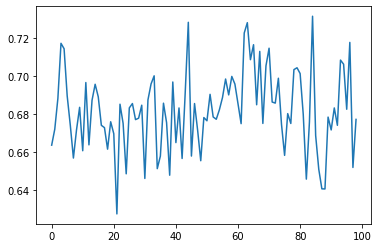

In [270]:
print(f'train examples {train_examples}')
print(f'label list {label_list}')
print(f'max_seq_length {max_seq_length}')
print(f'tokenizer {tokenizer}')

if do_train:
    train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer)
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_examples))
    logger.info("  Batch size = %d", train_batch_size)
    logger.info("  Num steps = %d", num_train_steps)

    all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)

    train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    if local_rank == -1:
        train_sampler = RandomSampler(train_data)
    else:
        train_sampler = DistributedSampler(train_data)

    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)
    model.train()

    for epo in trange(int(num_train_epochs), desc="Epoch"):
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            loss, logits = model(input_ids, segment_ids, input_mask, label_ids)

            if n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu.
            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward() # this updates the weights, and should help CAMLBERT learn!!!
            train_loss_history.append(loss.item())
            tr_loss += loss.item()
            nb_tr_examples += input_ids.size(0)
            nb_tr_steps += 1

            if (step + 1) % gradient_accumulation_steps == 0:
                model.zero_grad()
                global_step += 1

            if (step+1) % 200 == 0:
                string = 'step '+str(step+1)
                print (string)

        train_loss = tr_loss
        global_step_check = global_step
        number_training_steps = nb_tr_steps

    string = bert_model_folder + 'new_camlbert_model_state.bin'
    torch.save(model.state_dict(), string)

    fig1 = plt.figure()
    plt.plot(train_loss_history)
    fig_path = os.path.join(results_location, 'loss_history.png')
    plt.savefig(fig_path , dpi=fig1.dpi)


max_seq_length is the maximum total input sequence length after WordPiece tokenization. Sequences longer than this will be truncated, and sequences shorter than this will be padded.

eval_batch_size is the total batch size for eval.

### New Model Preds

In [271]:
do_eval

True

05/07/2022 19:36:10 - INFO - __main__ -   Retrieving data examples from /content/drive/My Drive/CAMLBERT/caml_data/test.csv
05/07/2022 19:36:10 - INFO - __main__ -   *** Example ***
05/07/2022 19:36:10 - INFO - __main__ -   guid: test-0
05/07/2022 19:36:10 - INFO - __main__ -   tokens: [CLS] lung clear without evidence focal airspace disease evidence p ##ne ##um ##otho ##ra ##x large pl ##eur ##al e ##ff ##usion cardiac media ##sti ##nal con ##tour within normal limit xx ##xx un ##rem ##ark ##able radio ##graphic evidence acute card ##io ##pu ##lm ##ona ##ry disease [SEP]
05/07/2022 19:36:10 - INFO - __main__ -   input_ids: 101 11192 3154 2302 3350 15918 29357 4295 3350 1052 2638 2819 29288 2527 2595 2312 20228 11236 2389 1041 4246 14499 15050 2865 16643 12032 9530 21163 2306 3671 5787 22038 20348 4895 28578 17007 3085 2557 14773 3350 11325 4003 3695 14289 13728 7856 2854 4295 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Will be converting examples to features.


05/07/2022 19:36:10 - INFO - __main__ -   ***** Running evaluation *****
05/07/2022 19:36:10 - INFO - __main__ -     Num examples = 393
05/07/2022 19:36:10 - INFO - __main__ -     Batch size = 32


[<__main__.InputFeatures object at 0x7facd6c7cf50>, <__main__.InputFeatures object at 0x7facc3538b90>, <__main__.InputFeatures object at 0x7facd6c6a690>, <__main__.InputFeatures object at 0x7facc3530350>, <__main__.InputFeatures object at 0x7facd6c7cd10>, <__main__.InputFeatures object at 0x7facd6c6a810>, <__main__.InputFeatures object at 0x7facd6c6a250>, <__main__.InputFeatures object at 0x7facd6c8b6d0>, <__main__.InputFeatures object at 0x7facc3648910>, <__main__.InputFeatures object at 0x7facc3538390>, <__main__.InputFeatures object at 0x7facc3538990>, <__main__.InputFeatures object at 0x7facc3538590>, <__main__.InputFeatures object at 0x7facc35302d0>, <__main__.InputFeatures object at 0x7facc3530e50>, <__main__.InputFeatures object at 0x7facc3530a50>, <__main__.InputFeatures object at 0x7facc35309d0>, <__main__.InputFeatures object at 0x7facc3538210>, <__main__.InputFeatures object at 0x7facc3538e50>, <__main__.InputFeatures object at 0x7facc35380d0>, <__main__.InputFeatures object

  0%|          | 0/13 [00:00<?, ?it/s]

LOGITS SHAPE: torch.Size([32, 1])


  8%|▊         | 1/13 [00:00<00:03,  3.15it/s]

tensor([[ 0.3252],
        [-0.2875],
        [-0.3114],
        [ 0.1604]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.437700       0
1  0.580596       1
2  0.428623       1
3  0.422784       0
4  0.540012       1
5  0.480686       1
6  0.433120       0
7  0.514380       1
8  0.499826       1
9  0.464214       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       0
1              1            0       1
2              0            1       1
3              0            1       0
4              1            0       1
5              0            1       1
6              0            1       0
7              1            0       1
8              0            1       1
9              0            1       1
10             0            1       0
11             0            1       0
12             0            1       1
13             0            1       1
14             0            1       1
15   

 15%|█▌        | 2/13 [00:00<00:03,  3.24it/s]

tensor([[ 0.0494],
        [-0.3148],
        [-0.0347],
        [-0.1460]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.433366       1
1  0.512337       1
2  0.421937       0
3  0.491324       1
4  0.463553       1
5  0.493410       1
6  0.408045       0
7  0.421251       0
8  0.388426       0
9  0.433432       0
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       1
1              1            0       1
2              0            1       0
3              0            1       1
4              0            1       1
5              0            1       1
6              0            1       0
7              0            1       0
8              0            1       0
9              0            1       0
10             0            1       0
11             0            1       1
12             1            0       1
13             0            1       1
14             0            1       0
15   

 23%|██▎       | 3/13 [00:00<00:03,  3.27it/s]

tensor([[-0.4539],
        [-0.1000],
        [-0.2673],
        [ 0.7995]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.488163       1
1  0.388426       0
2  0.475013       1
3  0.433577       0
4  0.689873       1
5  0.285209       1
6  0.456503       1
7  0.542875       1
8  0.474849       0
9  0.552553       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       1
1              0            1       0
2              0            1       1
3              0            1       0
4              1            0       1
5              0            1       1
6              0            1       1
7              1            0       1
8              0            1       0
9              1            0       1
10             0            1       0
11             0            1       1
12             0            1       1
13             0            1       0
14             0            1       0
15   

 31%|███       | 4/13 [00:01<00:02,  3.28it/s]

tensor([[-0.2443],
        [-0.0642],
        [-0.3645],
        [-0.2673]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.468584       0
1  0.439215       0
2  0.483955       1
3  0.409869       1
4  0.433577       0
5  0.458472       1
6  0.441008       1
7  0.471079       0
8  0.555680       1
9  0.530869       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       0
1              0            1       0
2              0            1       1
3              0            1       1
4              0            1       0
5              0            1       1
6              0            1       1
7              0            1       0
8              1            0       1
9              1            0       1
10             0            1       0
11             1            0       1
12             0            1       0
13             1            0       1
14             0            1       1
15   

 38%|███▊      | 5/13 [00:01<00:02,  3.29it/s]

tensor([[ 0.2921],
        [ 0.3433],
        [-0.5489],
        [-0.0916]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.324076       1
1  0.572511       1
2  0.584981       1
3  0.366117       0
4  0.477107       1
5  0.347655       1
6  0.528785       1
7  0.454476       0
8  0.443633       0
9  0.573079       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       1
1              1            0       1
2              1            0       1
3              0            1       0
4              0            1       1
5              0            1       1
6              1            0       1
7              0            1       0
8              0            1       0
9              1            0       1
10             1            0       1
11             0            1       0
12             0            1       1
13             0            1       0
14             1            0       1
15   

 46%|████▌     | 6/13 [00:01<00:02,  3.30it/s]

tensor([[ 0.0229],
        [ 0.0294],
        [-0.2339],
        [-0.1403]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.465939       1
1  0.505714       1
2  0.507353       0
3  0.441780       1
4  0.464984       1
5  0.481679       1
6  0.406786       1
7  0.479716       0
8  0.472856       1
9  0.439111       0
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       1
1              1            0       1
2              1            0       0
3              0            1       1
4              0            1       1
5              0            1       1
6              0            1       1
7              0            1       0
8              0            1       1
9              0            1       0
10             0            1       1
11             0            1       1
12             0            1       0
13             0            1       0
14             0            1       0
15   

 54%|█████▍    | 7/13 [00:02<00:01,  3.31it/s]

tensor([[-0.3406],
        [-0.2223],
        [ 0.2211],
        [-0.0907]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.481757       1
1  0.415666       1
2  0.444648       1
3  0.555041       1
4  0.477353       1
5  0.460396       0
6  0.503377       1
7  0.457783       0
8  0.478938       0
9  0.531128       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       1
1              0            1       1
2              0            1       1
3              1            0       1
4              0            1       1
5              0            1       0
6              1            0       1
7              0            1       0
8              0            1       0
9              1            0       1
10             0            1       0
11             0            1       0
12             1            0       1
13             0            1       0
14             0            1       1
15   

 62%|██████▏   | 8/13 [00:02<00:01,  3.31it/s]

tensor([[-0.0870],
        [ 0.0828],
        [ 0.1284],
        [-0.1194]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.570775       1
1  0.478260       1
2  0.520697       1
3  0.532056       1
4  0.470174       1
5  0.486258       1
6  0.600902       1
7  0.487409       1
8  0.426333       0
9  0.519673       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              1            0       1
1              0            1       1
2              1            0       1
3              1            0       1
4              0            1       1
5              0            1       1
6              1            0       1
7              0            1       1
8              0            1       0
9              1            0       1
10             0            1       1
11             0            1       1
12             0            1       0
13             0            1       0
14             1            0       1
15   

 69%|██████▉   | 9/13 [00:02<00:01,  3.32it/s]

tensor([[-0.0280],
        [ 0.0553],
        [-0.3721],
        [-0.2590]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.408045       0
1  0.493000       1
2  0.513817       1
3  0.408045       0
4  0.435597       1
5  0.529143       1
6  0.467297       1
7  0.439111       0
8  0.412080       0
9  0.486595       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       0
1              0            1       1
2              1            0       1
3              0            1       0
4              0            1       1
5              1            0       1
6              0            1       1
7              0            1       0
8              0            1       0
9              0            1       1
10             0            1       0
11             0            1       0
12             0            1       0
13             0            1       1
14             0            1       0
15   

 77%|███████▋  | 10/13 [00:03<00:00,  3.31it/s]

tensor([[-0.0517],
        [-0.3148],
        [ 0.1166],
        [ 0.2373]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.453930       0
1  0.487081       1
2  0.421937       0
3  0.529114       1
4  0.559054       1
5  0.433577       0
6  0.488305       1
7  0.415786       0
8  0.431839       1
9  0.367905       0
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       0
1              0            1       1
2              0            1       0
3              1            0       1
4              1            0       1
5              0            1       0
6              0            1       1
7              0            1       0
8              0            1       1
9              0            1       0
10             0            1       0
11             1            0       1
12             0            1       1
13             0            1       1
14             0            1       0
15   

 85%|████████▍ | 11/13 [00:03<00:00,  3.31it/s]

tensor([[ 0.2605],
        [-0.5329],
        [-0.2384],
        [-0.3341]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.501514       1
1  0.564748       1
2  0.369835       1
3  0.440676       1
4  0.417251       0
5  0.454839       1
6  0.497591       0
7  0.422269       0
8  0.416076       1
9  0.470077       0
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              1            0       1
1              1            0       1
2              0            1       1
3              0            1       1
4              0            1       0
5              0            1       1
6              0            1       0
7              0            1       0
8              0            1       1
9              0            1       0
10             0            1       1
11             0            1       0
12             0            1       0
13             0            1       1
14             1            0       1
15   

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

tensor([[-0.1019],
        [ 0.0383],
        [-0.1449],
        [-0.1481]], device='cuda:0')
NEW LOGITS SHAPE: (32,)
SANITY DF LOGITS VS LABELS
:      logits  labels
0  0.468584       0
1  0.474537       1
2  0.509582       1
3  0.463834       1
4  0.463035       1
5  0.453749       0
6  0.400813       1
7  0.446649       0
8  0.546216       1
9  0.491903       1
SANITY OUTPUT DF 
:     orig outputs  rev_outputs  labels
0              0            1       0
1              0            1       1
2              1            0       1
3              0            1       1
4              0            1       1
5              0            1       0
6              0            1       1
7              0            1       0
8              1            0       1
9              0            1       1
10             1            0       1
11             1            0       1
12             0            1       0
13             0            1       0
14             1            0       1
15   

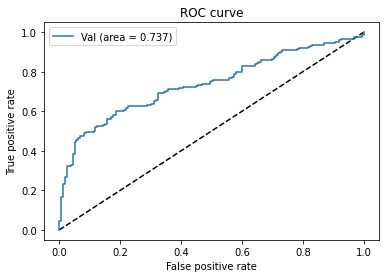

05/07/2022 19:36:14 - INFO - __main__ -   ***** Eval results *****
05/07/2022 19:36:14 - INFO - __main__ -     RP80 = 0.6266094420600858
05/07/2022 19:36:14 - INFO - __main__ -     eval_accuracy = 0.03307888040712468
05/07/2022 19:36:14 - INFO - __main__ -     eval_loss = 0.673754659982828
05/07/2022 19:36:14 - INFO - __main__ -     global_step = 99
05/07/2022 19:36:14 - INFO - __main__ -     rev_eval_accuracy = 0.03307888040712468
05/07/2022 19:36:14 - INFO - __main__ -     training loss = 0.6818302893879438


Recall at Precision of 80 is {} 0.6266094420600858


<Figure size 432x288 with 0 Axes>

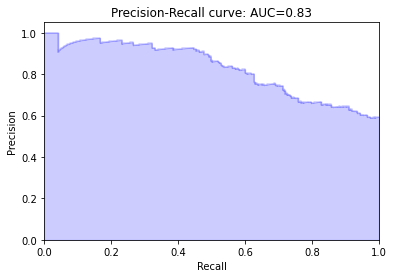

In [277]:
m = nn.Sigmoid()
if do_eval:

    eval_examples = processor.get_test_examples(data_dir)
    eval_features = convert_examples_to_features(
        eval_examples, label_list, max_seq_length, tokenizer)
    print(eval_features)

    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_examples))
    logger.info("  Batch size = %d", eval_batch_size)

    all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

    eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    if local_rank == -1:
        eval_sampler = SequentialSampler(eval_data)
    else:
        eval_sampler = DistributedSampler(eval_data)

    eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)
    model.eval()
    eval_loss, eval_accuracy, opposite_accuracy = 0, 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    true_labels=[]
    pred_labels=[]
    rev_labels=[]
    logits_history=[]

    for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader):

        input_ids = input_ids.to(device)
        # print(f'input ids: {input_ids}')
        input_mask = input_mask.to(device)
        # print(f'input mask: {input_mask}')
        segment_ids = segment_ids.to(device) # this is not used in the other article
        # print(f'segment ids: {segment_ids}')

        label_ids = label_ids.to(device)
        # print(f'label ids: {label_ids}')

        with torch.no_grad():
            tmp_eval_loss, temp_logits = model(input_ids, segment_ids, input_mask, label_ids)
            logits = model(input_ids, segment_ids, input_mask)
            print(f'LOGITS SHAPE: {logits.shape}')
            print(logits[1:5,])

        logits = torch.squeeze(m(logits),dim = -1).detach().cpu().numpy() # squeezing dimension out of the return of sigmoid
        print(f'NEW LOGITS SHAPE: {logits.shape}')

        label_ids = label_ids.to('cpu').numpy()

        # MY EXPLORATION OF REVERSED POLARITY
        sanity_df = pd.DataFrame({'logits':logits, 'labels':label_ids})
        print(f'SANITY DF LOGITS VS LABELS\n: {sanity_df.head(10)}')

        outputs_orig = np.asarray([1 if i else 0 for i in (logits.flatten()>=0.5)]) # ORIGINAL POLARITY
        outputs_rev = np.asarray([1 if i else 0 for i in (logits.flatten()< 0.5)]) # TRYING THE REVERSE POLARITY
        ouput_sanity_df = pd.DataFrame({'orig outputs':outputs_orig, 'rev_outputs': outputs_rev, 'labels': label_ids})
        print(f'SANITY OUTPUT DF \n: {ouput_sanity_df.head(20)}')

        # CHOOSE WHETHER TO USE REVERSE OR NOT
        use_reverse_logits = False
        if (use_reverse_logits == True):
          outputs = outputs_rev
          opposite = outputs_orig
        else:
          outputs = outputs_orig
          opposite = outputs_rev


        tmp_eval_accuracy = np.sum(outputs == label_ids).all() # currently with reversed output
        opp_eval_accuracy = np.sum(opposite == label_ids).all() # currently with reversed output

        true_labels = true_labels + label_ids.flatten().tolist()
        pred_labels = pred_labels + outputs_orig.flatten().tolist()
        rev_labels = rev_labels + outputs.flatten().tolist()
        
        logits_history = logits_history + logits.flatten().tolist()

        true_pred_match = np.equal(true_labels, pred_labels)
        opposite_match = np.invert(true_pred_match)
        compare_df = pd.DataFrame({'true_labels': true_labels, 'pred_labels': pred_labels, 
                                   'match': true_pred_match, 'rev_match': opposite_match})
        print('true_labels / pred_labels / rev_outputs\n', compare_df.head(15))

        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        opposite_accuracy += opp_eval_accuracy

        nb_eval_examples += input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_examples
    reversed_accuracy = opposite_accuracy / nb_eval_examples

    df = pd.DataFrame({'logits':logits_history, 'pred_label': pred_labels, 'label':true_labels})

    # string = 'logits_clinicalbert_'+readmission_mode+'_chunks.csv'
    string = 'camlbert_logit_chunks.csv'

    df.to_csv(os.path.join(results_location, string))

    df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))
    # reverse_logits = np.array(logits_history)
    # reverse_logits = 1 - reverse_logits

    # print('SHAPE ORIG', logits.shape)
    # print('SHAPE', reverse_logits.shape)
    # reverse_logits = reverse_logits.flatten().tolist()
    # print(len(reverse_logits), reverse_logits[0])
    print()
    print(f'DF TEST\n{df_test.head()}')
    print(f'LOGITS HISTORY\n{logits_history}')
    fpr, tpr, df_out = vote_score(df_test, logits_history, results_location)
    # fpr, tpr, df_out = vote_score(df_test, reverse_logits, readmission_mode, results_location)

    # string = 'logits_clinicalbert_'+readmission_mode+'_readmissions.csv'
    string = 'camlbert_logits.csv'

    df_out.to_csv(os.path.join(results_location,string))

    rp80 = vote_pr_curve(df_test, logits_history, results_location)

    result = {'eval_loss': eval_loss,
              'eval_accuracy': eval_accuracy,    
              'rev_eval_accuracy' : reversed_accuracy,         
              'global_step': global_step_check,
              'training loss': train_loss/number_training_steps,
              'RP80': rp80}

    output_eval_file = os.path.join(results_location, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results *****")
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

In [278]:
print('Everything ran OK!')

This version of COLAB works!
